# Machine Learning for Classification<img align="right" src="image/gistda.png" width="200" height="200">

This is a case study to classify urban area by using Machine learning method.



<table class="ee-notebook-buttons" align="left">
    <td><a target="_parent"  href="https://nbviewer.org/github/Pathakorn40/rice-detection/blob/main/Tutorial/Machine_learning.ipynb"><img width=26px src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/38/Jupyter_logo.svg/883px-Jupyter_logo.svg.png" />Notebook Viewer</a></td>
</table>

### Imaport packages

In [3]:
# import datacube
import matplotlib
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from odc.io.cgroups import get_cpu_quota
from sklearn import tree
from sklearn import model_selection
from sklearn.metrics import accuracy_score
# from datacube.utils import geometry
# from datacube.utils.cog import write_cog
# from dea_tools.classification import collect_training_data, predict_xr
from dream_river.plotimg import show_map, show_vector, geojson_add_Newcol 
from dream_river.geobox import merge, convert_geojson_CRS

from pystac_client import Client
from odc.stac import configure_rio, stac_load
from dask.distributed import Client as DaskClient
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

client = DaskClient()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 39.15 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40109,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 39.15 GiB
Comm: tcp://127.0.0.1:39229,Total threads: 2
Dashboard: http://127.0.0.1:43377/status,Memory: 9.79 GiB
Nanny: tcp://127.0.0.1:40247,


### Create training data (Draw polygons) 

The Drawing tool was used to create trianing data. This case study created 3 types of landuse to train the model that compose of water, urban and green.

In [6]:
Map =show_map()
Map

### Display output from drawing

In [7]:
# get path of files
path = ['training/green_area_sawan.geojson','training/water_sawan.geojson','training/urban_sawan.geojson']
show_vector(path)

### Data preparation

In [8]:
# open file in geopandas dataframe
gdf = gpd.read_file('training/urban_sawan.geojson')

# to see 5 first rows
gdf.head()

,class,geometry
0,111,"POLYGON ((100.13 15.705, 100.13 15.706, 100.13..."
1,111,"POLYGON ((100.14 15.707, 100.14 15.705, 100.14..."
2,111,"POLYGON ((100.14 15.706, 100.14 15.705, 100.14..."
3,111,"POLYGON ((100.15 15.713, 100.15 15.715, 100.15..."
4,111,"POLYGON ((100.15 15.718, 100.15 15.718, 100.15..."


#### - Add new column

In this case study, we create "class" in column name and add value into that column follow file name to categorize the type of data like: 

green_area = 111

water = 112

urban = 113

In [5]:
# func to add new colume and assign value
geojson_add_Newcol('training/urban_sawan.geojson')

num of rows:  18


18

In [9]:
# func to add new colume and assign value
geojson_add_Newcol('training/green_area_sawan.geojson')

num of rows:  20


20

In [10]:
# func to add new colume and assign value
geojson_add_Newcol('training/water_sawan.geojson')

num of rows:  14


14

#### - Explore new column

You will see new column was created

In [11]:
new_green = gpd.read_file('training/green_area_sawan.geojson')
new_green.head()

,class,,geometry
0,112,111,"POLYGON ((100.12 15.716, 100.12 15.717, 100.12..."
1,112,111,"POLYGON ((100.13 15.718, 100.13 15.719, 100.13..."
2,112,111,"POLYGON ((100.13 15.714, 100.13 15.714, 100.13..."
3,112,111,"POLYGON ((100.13 15.713, 100.14 15.713, 100.14..."
4,112,111,"POLYGON ((100.13 15.713, 100.13 15.713, 100.13..."


#### - Merge data 

The three geojson files was created follow above steps, We need to merge them together to train classification model.

In [12]:
# assige input path
file =['training/green_area_sawan.geojson','training/urban_sawan.geojson','training/water_sawan.geojson']

# assign output file path
output = 'training/model_training.geojson'

# merge function
merge(file,output)

#### - Explore merge output

In [4]:
merge_out = gpd.read_file('training/model_training.geojson')
merge_out.tail()

,class,,geometry
47,113,NaN,"POLYGON ((100.07 15.686, 100.07 15.687, 100.07..."
48,113,NaN,"POLYGON ((100.13 15.702, 100.13 15.704, 100.13..."
49,113,NaN,"POLYGON ((100.11 15.732, 100.11 15.733, 100.11..."
50,113,NaN,"POLYGON ((100.12 15.73, 100.12 15.73, 100.12 1..."
51,113,NaN,"POLYGON ((100.14 15.722, 100.14 15.724, 100.15..."


#### - Convert Geo Coodinate Refference System(CRS)

This case study have to convert the CRS from 4326 to 32647 to access the data cube of Gistda.

In [5]:
# check coordinate system of data
merge_out.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
# set input output path
input_path = 'training/model_training.geojson'
output_path = 'training/model_training32647.geojson'

# function to convert CRS
convert_geojson_CRS(input_path, output_path, crs=32647)

In [7]:
# explore output 
crs_out = gpd.read_file(output_path)
crs_out.crs

<Projected CRS: EPSG:32647>
Name: WGS 84 / UTM zone 47N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 96°E and 102°E, northern hemisphere between equator and 84°N, onshore and offshore. China. Indonesia. Laos. Malaysia - West Malaysia. Mongolia. Myanmar (Burma). Russian Federation. Thailand.
- bounds: (96.0, 0.0, 102.0, 84.0)
Coordinate Operation:
- name: UTM zone 47N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Extract training data using a shapefile

To train our model, we need to obtain satellite data that corresponds with the labelled input data locations above. 
The function below takes our shapefile containing class labels and extracts the specified product within these areas into a single array.

In [8]:
# Load input data shapefile
input_data = gpd.read_file('training/model_training32647.geojson')

# Plot first five rows
input_data.head()

,class,,geometry
0,112,111.0,"POLYGON ((6.2e+05 1.74e+06, 6.2e+05 1.74e+06, ..."
1,112,111.0,"POLYGON ((6.21e+05 1.74e+06, 6.21e+05 1.74e+06..."
2,112,111.0,"POLYGON ((6.21e+05 1.74e+06, 6.21e+05 1.74e+06..."
3,112,111.0,"POLYGON ((6.22e+05 1.74e+06, 6.22e+05 1.74e+06..."
4,112,111.0,"POLYGON ((6.22e+05 1.74e+06, 6.22e+05 1.74e+06..."


In [9]:
input_data.crs

<Projected CRS: EPSG:32647>
Name: WGS 84 / UTM zone 47N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 96°E and 102°E, northern hemisphere between equator and 84°N, onshore and offshore. China. Indonesia. Laos. Malaysia - West Malaysia. Mongolia. Myanmar (Burma). Russian Federation. Thailand.
- bounds: (96.0, 0.0, 102.0, 84.0)
Coordinate Operation:
- name: UTM zone 47N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
field = 'class'
time = ("2018-11-01","2018-11-10")
zonal_stats = 'median'
resolution = (-30, 30)
output_crs= "EPSG:32647"

In [11]:
#set collection configuration
collections = ["LANDSAT8_SR_C2L2"]
config = {
    "LANDSAT8_SR_C2L2": {
        "assets": {
            "*": {
                "data_type": "uint16",
                "nodata": 0,
                "unit": "unitless",
            },
            "aerosol_qa": {
                "data_type": "uint8",
                "nodata": 0,
                "unit": "bit",
            },
            "pixel_qa": {
                "data_type": "uint16",
                "nodata": 0,
                "unit": "bit",
            },
            "radsat_qa": {
                "data_type": "uint16",
                "units": "bit",
                "nodata": 0,
            },
        },
    }
}

In [12]:
# connect to the GISTDA ODC STAC Catalog
catalog = Client.open(url="http://110.78.252.138/stac")
query = catalog.search(
    collections=collections, datetime=f"{time[0]}/{time[1]}"
)
items = list(query.items())
print(f"Found: {len(items):d} datasets")
for ds in items:
    print(ds.to_dict()['properties']['title'])

Found: 38 datasets
LC08_L2SR_132046_20181101_20200830_02_T1
LC08_L2SR_132047_20181101_20200830_02_T1
LC08_L2SR_132048_20181101_20200830_02_T1
LC08_L2SR_130046_20181103_20200830_02_T1
LC08_L2SR_130047_20181103_20200830_02_T1
LC08_L2SR_130048_20181103_20200830_02_T1
LC08_L2SR_130049_20181103_20200830_02_T1
LC08_L2SR_130050_20181103_20200830_02_T1
LC08_L2SR_130051_20181103_20200830_02_T1
LC08_L2SR_130052_20181103_20200830_02_T1
LC08_L2SR_130053_20181103_20200830_02_T1
LC08_L2SR_130054_20181103_20200830_02_T1
LC08_L2SR_130055_20181103_20200830_02_T1
LC08_L2SR_130056_20181103_20200830_02_T1
LC08_L2SR_128047_20181105_20200830_02_T1
LC08_L2SR_128048_20181105_20200830_02_T1
LC08_L2SR_128049_20181105_20200830_02_T1
LC08_L2SR_128050_20181105_20200830_02_T1
LC08_L2SR_128051_20181105_20200830_02_T1
LC08_L2SR_128052_20181105_20200830_02_T1
LC08_L2SR_128053_20181105_20200830_02_T2
LC08_L2SR_128054_20181105_20200830_02_T1
LC08_L2SR_128055_20181105_20200830_02_T1
LC08_L2SR_128056_20181105_20200830_02_

In [13]:
ncpus=round(get_cpu_quota())
print(ncpus)

0


In [14]:
query = {
    "items": items,
    "bands": ['blue','green','red',"nir"],
    "stac_cfg":config,
    "chunks":{'time':2, 'x':200, 'y':200},
    "groupby":"solar_day"
}
# query = {
#     "measurements": ['blue','green','red',"nir"],
#     'time': time,
#     'resolution': resolution,
#     'output_crs': output_crs,
#     'group_by': 'solar_day',
# }

The following function is passed to `collect_training_data`. 

It extracts bands from the [ls8_collections_sr_scene](https://datacube.gistda.or.th/explorer/products/ls8_collections_l1_scene) product as feature layers along side our labelled data so we can train a supervised model.

The feature function can be modified to extract different combinations of features within the datacube, it is one of the important parts to experiment with when generating your own model.

In [15]:
def custom_function(query):

    # Load data 
    result = stac_load(**query)
    display(result)
    
    #     # Initialise datacube
    # dc = datacube.Datacube(app='custom_feature_layers')

    # # Load data using query
    # result = dc.load(product='ls8_collections_sr_scene', **query)

    
    return result

# custom_function(query)

> **Note:** The following cell can take several minutes to run. The class labels will be contained in the first column of the output array called model_input, the corresponding variable names captured in the list column_names

In [36]:
# classification.py
"""
Machine learning classification tools for analysing remote sensing data
using the Open Data Cube.

License: The code in this notebook is licensed under the Apache License,
Version 2.0 (https://www.apache.org/licenses/LICENSE-2.0). Digital Earth
Australia data is licensed under the Creative Commons by Attribution 4.0
license (https://creativecommons.org/licenses/by/4.0/).

Contact: If you need assistance, please post a question on the Open Data
Cube Slack channel (http://slack.opendatacube.org/) or on the GIS Stack
Exchange (https://gis.stackexchange.com/questions/ask?tags=open-data-cube)
using the `open-data-cube` tag (you can view previously asked questions
here: https://gis.stackexchange.com/questions/tagged/open-data-cube).

If you would like to report an issue with this script, you can file one
on GitHub (https://github.com/GeoscienceAustralia/dea-notebooks/issues/new).

Last modified: May 2021
"""

import os
import sys
import joblib
import numpy as np
import pandas as pd
import xarray as xr
import time
import warnings
from datetime import timedelta
import geopandas as gpd
from copy import deepcopy
from tqdm.auto import tqdm
import multiprocessing as mp
import matplotlib.pyplot as plt

from typing import Callable, Tuple, Any, Optional, List, Dict

import dask.array as da
from dask_ml.wrappers import ParallelPostFit
import dask.distributed as dd
from dask.diagnostics import ProgressBar

from sklearn.cluster import KMeans
from sklearn.utils import check_random_state
from abc import ABCMeta, abstractmethod
from sklearn.base import ClusterMixin
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.model_selection import BaseCrossValidator

from datacube.utils.geometry import assign_crs
from datacube.utils import geometry
from dea_tools.spatial import xr_rasterize


def sklearn_flatten(input_xr):
    """
    Reshape a DataArray or Dataset with spatial (and optionally
    temporal) structure into an np.array with the spatial and temporal
    dimensions flattened into one dimension.

    This flattening procedure enables DataArrays and Datasets to be used
    to train and predict
    with sklearn models.

    Last modified: September 2019

    Parameters
    ----------
    input_xr : xarray.DataArray or xarray.Dataset
        Must have dimensions 'x' and 'y', may have dimension 'time'.
        Dimensions other than 'x', 'y' and 'time' are unaffected by the
        flattening.

    Returns
    ----------
    input_np : numpy.array
        A numpy array corresponding to input_xr.data (or
        input_xr.to_array().data), with dimensions 'x','y' and 'time'
        flattened into a single dimension, which is the first axis of
        the returned array. input_np contains no NaNs.

    """
    # cast input Datasets to DataArray
    if isinstance(input_xr, xr.Dataset):
        input_xr = input_xr.to_array()

    # stack across pixel dimensions, handling timeseries if necessary
    if "time" in input_xr.dims:
        stacked = input_xr.stack(z=["x", "y", "time"])
    else:
        stacked = input_xr.stack(z=["x", "y"])

    # finding 'bands' dimensions in each pixel - these will not be
    # flattened as their context is important for sklearn
    pxdims = []
    for dim in stacked.dims:
        if dim != "z":
            pxdims.append(dim)

    # mask NaNs - we mask pixels with NaNs in *any* band, because
    # sklearn cannot accept NaNs as input
    mask = np.isnan(stacked)
    if len(pxdims) != 0:
        mask = mask.any(dim=pxdims)

    # turn the mask into a numpy array (boolean indexing with xarrays
    # acts weird)
    mask = mask.data

    # the dimension we are masking along ('z') needs to be the first
    # dimension in the underlying np array for the boolean indexing to work
    stacked = stacked.transpose("z", *pxdims)
    input_np = stacked.data[~mask]

    return input_np


def sklearn_unflatten(output_np, input_xr):
    """
    Reshape a numpy array with no 'missing' elements (NaNs) and
    'flattened' spatiotemporal structure into a DataArray matching the
    spatiotemporal structure of the DataArray

    This enables an sklearn model's prediction to be remapped to the
    correct pixels in the input DataArray or Dataset.

    Last modified: September 2019

    Parameters
    ----------
    output_np : numpy.array
        The first dimension's length should correspond to the number of
        valid (non-NaN) pixels in input_xr.
    input_xr : xarray.DataArray or xarray.Dataset
        Must have dimensions 'x' and 'y', may have dimension 'time'.
        Dimensions other than 'x', 'y' and 'time' are unaffected by the
        flattening.

    Returns
    ----------
    output_xr : xarray.DataArray
        An xarray.DataArray with the same dimensions 'x', 'y' and 'time'
        as input_xr, and the same valid (non-NaN) pixels. These pixels
        are set to match the data in output_np.

    """

    # the output of a sklearn model prediction should just be a numpy array
    # with size matching x*y*time for the input DataArray/Dataset.

    # cast input Datasets to DataArray
    if isinstance(input_xr, xr.Dataset):
        input_xr = input_xr.to_array()

    # generate the same mask we used to create the input to the sklearn model
    if "time" in input_xr.dims:
        stacked = input_xr.stack(z=["x", "y", "time"])
    else:
        stacked = input_xr.stack(z=["x", "y"])

    pxdims = []
    for dim in stacked.dims:
        if dim != "z":
            pxdims.append(dim)

    mask = np.isnan(stacked)
    if len(pxdims) != 0:
        mask = mask.any(dim=pxdims)

    # handle multivariable output
    output_px_shape = ()
    if len(output_np.shape[1:]):
        output_px_shape = output_np.shape[1:]

    # use the mask to put the data in all the right places
    output_ma = np.ma.empty((len(stacked.z), *output_px_shape))
    output_ma[~mask] = output_np
    output_ma[mask] = np.ma.masked

    # set the stacked coordinate to match the input
    output_xr = xr.DataArray(
        output_ma,
        coords={"z": stacked["z"]},
        dims=[
            "z",
            *["output_dim_" + str(idx) for idx in range(len(output_px_shape))],
        ],
    )

    output_xr = output_xr.unstack()

    return output_xr


def fit_xr(model, input_xr):
    """
    Utilise our wrappers to fit a vanilla sklearn model.

    Last modified: September 2019

    Parameters
    ----------
    model : scikit-learn model or compatible object
        Must have a fit() method that takes numpy arrays.
    input_xr : xarray.DataArray or xarray.Dataset.
        Must have dimensions 'x' and 'y', may have dimension 'time'.

    Returns
    ----------
    model : a scikit-learn model which has been fitted to the data in
    the pixels of input_xr.

    """

    model = model.fit(sklearn_flatten(input_xr))
    return model


def predict_xr(
    model,
    input_xr,
    chunk_size=None,
    persist=False,
    proba=False,
    clean=False,
    return_input=False,
):
    """
    Using dask-ml ParallelPostfit(), runs  the parallel
    predict and predict_proba methods of sklearn
    estimators. Useful for running predictions
    on a larger-than-RAM datasets.

    Last modified: September 2020

    Parameters
    ----------
    model : scikit-learn model or compatible object
        Must have a .predict() method that takes numpy arrays.
    input_xr : xarray.DataArray or xarray.Dataset.
        Must have dimensions 'x' and 'y'
    chunk_size : int
        The dask chunk size to use on the flattened array. If this
        is left as None, then the chunks size is inferred from the
        .chunks method on the `input_xr`
    persist : bool
        If True, and proba=True, then 'input_xr' data will be
        loaded into distributed memory. This will ensure data
        is not loaded twice for the prediction of probabilities,
        but this will only work if the data is not larger than
        distributed RAM.
    proba : bool
        If True, predict probabilities
    clean : bool
        If True, remove Infs and NaNs from input and output arrays
    return_input : bool
        If True, then the data variables in the 'input_xr' dataset will
        be appended to the output xarray dataset.

    Returns
    ----------
    output_xr : xarray.Dataset
        An xarray.Dataset containing the prediction output from model.
        if proba=True then dataset will also contain probabilites, and
        if return_input=True then dataset will have the input feature layers.
        Has the same spatiotemporal structure as input_xr.

    """
    # if input_xr isn't dask, coerce it
    dask = True
    if not bool(input_xr.chunks):
        dask = False
        input_xr = input_xr.chunk({"x": len(input_xr.x), "y": len(input_xr.y)})

    # set chunk size if not supplied
    if chunk_size is None:
        chunk_size = int(input_xr.chunks["x"][0]) * int(
            input_xr.chunks["y"][0]
        )

    def _predict_func(model, input_xr, persist, proba, clean, return_input):
        x, y, crs = input_xr.x, input_xr.y, input_xr.geobox.crs

        input_data = []

        for var_name in input_xr.data_vars:
            input_data.append(input_xr[var_name])

        input_data_flattened = []

        for arr in input_data:
            data = arr.data.flatten().rechunk(chunk_size)
            input_data_flattened.append(data)

        # reshape for prediction
        input_data_flattened = da.array(input_data_flattened).transpose()

        if clean == True:
            input_data_flattened = da.where(
                da.isfinite(input_data_flattened), input_data_flattened, 0
            )

        if (proba == True) & (persist == True):
            # persisting data so we don't require loading all the data twice
            input_data_flattened = input_data_flattened.persist()

        # apply the classification
        print("predicting...")
        out_class = model.predict(input_data_flattened)

        # Mask out NaN or Inf values in results
        if clean == True:
            out_class = da.where(da.isfinite(out_class), out_class, 0)

        # Reshape when writing out
        out_class = out_class.reshape(len(y), len(x))

        # stack back into xarray
        output_xr = xr.DataArray(
            out_class, coords={"x": x, "y": y}, dims=["y", "x"]
        )

        output_xr = output_xr.to_dataset(name="Predictions")

        if proba == True:
            print("   probabilities...")
            out_proba = model.predict_proba(input_data_flattened)

            # convert to %
            out_proba = da.max(out_proba, axis=1) * 100.0

            if clean == True:
                out_proba = da.where(da.isfinite(out_proba), out_proba, 0)

            out_proba = out_proba.reshape(len(y), len(x))

            out_proba = xr.DataArray(
                out_proba, coords={"x": x, "y": y}, dims=["y", "x"]
            )
            output_xr["Probabilities"] = out_proba

        if return_input == True:
            print("   input features...")
            # unflatten the input_data_flattened array and append
            # to the output_xr containin the predictions
            arr = input_xr.to_array()
            stacked = arr.stack(z=["y", "x"])

            # handle multivariable output
            output_px_shape = ()
            if len(input_data_flattened.shape[1:]):
                output_px_shape = input_data_flattened.shape[1:]

            output_features = input_data_flattened.reshape(
                (len(stacked.z), *output_px_shape)
            )

            # set the stacked coordinate to match the input
            output_features = xr.DataArray(
                output_features,
                coords={"z": stacked["z"]},
                dims=[
                    "z",
                    *[
                        "output_dim_" + str(idx)
                        for idx in range(len(output_px_shape))
                    ],
                ],
            ).unstack()

            # convert to dataset and rename arrays
            output_features = output_features.to_dataset(dim="output_dim_0")
            data_vars = list(input_xr.data_vars)
            output_features = output_features.rename(
                {i: j for i, j in zip(output_features.data_vars, data_vars)}
            )

            # merge with predictions
            output_xr = xr.merge(
                [output_xr, output_features], compat="override"
            )

        return assign_crs(output_xr, str(crs))

    if dask == True:
        # convert model to dask predict
        model = ParallelPostFit(model)
        with joblib.parallel_backend("dask"):
            output_xr = _predict_func(
                model, input_xr, persist, proba, clean, return_input
            )

    else:
        output_xr = _predict_func(
            model, input_xr, persist, proba, clean, return_input
        ).compute()

    return output_xr


class HiddenPrints:
    """
    For concealing unwanted print statements called by other functions
    """

    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, "w")

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


def _get_training_data_for_shp(
    gdf: gpd.GeoDataFrame,
    index: int,
    row: gpd.GeoSeries,
    out_arrs: List[np.ndarray],
    out_vars: List[List[str]],
    dc_query: Dict,
    return_coords: bool,
    feature_func: Optional[callable] = None,
    field: Optional[str] = None,
    zonal_stats: Optional[str] = None,
    time_field: Optional[str] = None,
    time_delta: Optional[timedelta] = None,
):
    """
    This is the core function that is triggered by `collect_training_data`.
    The `collect_training_data` function loops through geometries in a geopandas
    geodataframe and runs the code within `_get_training_data_for_shp`.
    Parameters are inherited from `collect_training_data`.
    See that function for information on the other params not listed below.

    Parameters
    ----------
    gdf : gpd.GeoDataFrame
        Geopandas GeoDataFrame containing geometries.
    index : int
        Index of the current geometry in the GeoDataFrame.
    row : gpd.GeoSeries
        GeoSeries representing the current row in the GeoDataFrame.
    out_arrs : List[np.ndarray]
        An empty list into which the training data arrays are stored.
    out_vars : List[List[str]]
        An empty list into which the data variable names are stored.
    dc_query : Dict
        ODC query.
    return_coords : bool
        Flag indicating whether to return coordinates in the dataset.
    feature_func : callable, optional
        Optional function to extract data based on `dc_query`. Defaults to None.
    field : str, optional
        Name of the class field. Defaults to None.
    zonal_stats : str, optional
        Zonal statistics method. Defaults to None.
    time_field : str, optional
        Name of the column containing timestamp data in the input gdf. Defaults to None.
    time_delta : timedelta, optional
        Time delta used to match a data point with all the scenes falling between
        `time_stamp - time_delta` and `time_stamp + time_delta`. Defaults to None.


    Returns
    --------
    Two lists, a list of numpy.arrays containing classes and extracted data for
    each pixel or polygon, and another containing the data variable names.

    """

    # prevent function altering dictionary kwargs
    dc_query = deepcopy(dc_query)

    # remove dask chunks if supplied as using
    # mulitprocessing for parallization
    if "dask_chunks" in dc_query.keys():
        dc_query.pop("dask_chunks", None)

    # set up query based on polygon
    geom = geometry.Geometry(geom=gdf.iloc[index].geometry, crs=gdf.crs)
    q = {"geopolygon": geom}
    # merge polygon query with user supplied query params
    dc_query.update(q)

    # Update time range if a time window is specified
    if time_delta is not None:
        timestamp = gdf.loc[index][time_field]
        start_time = timestamp - time_delta
        end_time = timestamp + time_delta
        timestamp = {"time": (start_time, end_time)}
        # merge time query with user supplied query params
        dc_query.update(timestamp)

    # Use input feature function
    data = feature_func(dc_query)

    # if no data is present then return
    if len(data) == 0:
        return

    if gdf.iloc[[index]].geometry.geom_type.values != "Point":
        # If the geometry type is a polygon extract all pixels
        # create polygon mask
        mask = xr_rasterize(gdf.iloc[[index]], data)
        data = data.where(mask)

    # Check that feature_func has removed time
    if "time" in data.dims:
        t = data.dims["time"]
        if t > 1 and time_delta is not None:
            raise ValueError(
                "After running the feature_func, the dataset still has "
                + str(t)
                + " time-steps, dataset must only have"
                + " x and y dimensions."
            )

    if return_coords == True:
        # turn coords into a variable in the ds
        data["x_coord"] = data.x + 0 * data.y
        data["y_coord"] = data.y + 0 * data.x

    # append ID measurement to dataset for tracking failures
    band = [m for m in data.data_vars][0]
    _id = xr.zeros_like(data[band])
    data["id"] = _id
    data["id"] = data["id"] + gdf.iloc[index]["id"]

    # If no zonal stats were requested then extract all pixel values
    if zonal_stats is None:
        flat_train = sklearn_flatten(data)
        flat_val = np.repeat(row[field], flat_train.shape[0])
        stacked = np.hstack((np.expand_dims(flat_val, axis=1), flat_train))

    elif zonal_stats in ["mean", "median", "max", "min"]:
        method_to_call = getattr(data, zonal_stats)
        flat_train = method_to_call()
        flat_train = flat_train.to_array()
        stacked = np.hstack((row[field], flat_train))

    else:
        raise Exception(
            zonal_stats
            + " is not one of the supported"
            + " reduce functions ('mean','median','max','min')"
        )

    out_arrs.append(stacked)
    out_vars.append([field] + list(data.data_vars))


def _get_training_data_parallel(
    gdf: gpd.GeoDataFrame,
    dc_query: str,
    ncpus: int,
    return_coords: bool,
    feature_func: Optional[Callable] = None,
    field: Optional[str] = None,
    zonal_stats: Optional[str] = None,
    time_field: Optional[str] = None,
    time_delta: Optional[int] = None,
) -> Tuple[List[str], List[Any]]:
    """
    Function passing the '_get_training_data_for_shp' function
    to a mulitprocessing.Pool.
    Inherits variables from 'collect_training_data()'.

    """
    print("***1", time_field, time_delta)
    # Check if dask-client is running
    try:
        zx = None
        zx = dd.get_client()
    except:
        pass

    if zx is not None:
        raise ValueError(
            "You have a Dask Client running, which prevents \n"
            "this function from multiprocessing. Close the client."
        )

    # instantiate lists that can be shared across processes
    print("***2")
    manager = mp.Manager()
    results = manager.list()
    column_names = manager.list()
    print("***3")
    # progress bar
    pbar = tqdm(total=len(gdf))

    def update(*a):
        pbar.update()
    print("***4")
    print(mp.Pool(ncpus))
    with mp.Pool(ncpus) as pool:
        for index, row in gdf.iterrows():
            print(index, row)
            pool.apply_async(
                _get_training_data_for_shp,
                [
                    gdf,
                    index,
                    row,
                    results,
                    column_names,
                    dc_query,
                    return_coords,
                    feature_func,
                    field,
                    zonal_stats,
                    time_field,
                    time_delta,
                ],
                callback=update,
            )
        print("***5")
        pool.close()
        pool.join()
        pbar.close()

    return column_names, results


def collect_training_data(
    gdf: gpd.GeoDataFrame,
    dc_query: dict,
    ncpus: int = 1,
    return_coords: bool = False,
    feature_func: callable = None,
    field: str = None,
    zonal_stats: str = None,
    clean: bool = True,
    fail_threshold: float = 0.02,
    fail_ratio: float = 0.5,
    max_retries: int = 3,
    time_field: str = None,
    time_delta: timedelta = None,
) -> Tuple[List[np.ndarray], List[str]]:
    """
    This function provides methods for gathering training data from the ODC over
    geometries stored within a geopandas geodataframe. The function will return a
    'model_input' array containing stacked training data arrays with all NaNs & Infs removed.
    In the instance where ncpus > 1, a parallel version of the function will be run
    (functions are passed to a mp.Pool()). This function can conduct zonal statistics if
    the supplied shapefile contains polygons. The 'feature_func' parameter defines what
    features to produce.

    Parameters
    ----------
    gdf : geopandas geodataframe
        geometry data in the form of a geopandas geodataframe
    dc_query : dictionary
        Datacube query object, should not contain lat and long (x or y)
        variables as these are supplied by the 'gdf' variable
    ncpus : int
        The number of cpus/processes over which to parallelize the gathering
        of training data (only if ncpus is > 1). Use 'mp.cpu_count()' to determine the number of
        cpus available on a machine. Defaults to 1.
    return_coords : bool
        If True, then the training data will contain two extra columns 'x_coord' and
        'y_coord' corresponding to the x,y coordinate of each sample. This variable can
        be useful for handling spatial autocorrelation between samples later in the ML workflow.
    feature_func : function
        A function for generating feature layers that is applied to the data within
        the bounds of the input geometry. The 'feature_func' must accept a 'dc_query'
        object, and return a single xarray.Dataset or xarray.DataArray containing
        2D coordinates (i.e x, y - no time dimension).
        e.g.
            def feature_function(query):
                dc = datacube.Datacube(app='feature_layers')
                ds = dc.load(**query)
                ds = ds.mean('time')
                return ds
    field : str
        Name of the column in the gdf that contains the class labels
    zonal_stats : string, optional
        An optional string giving the names of zonal statistics to calculate
        for each polygon. Default is None (all pixel values are returned). Supported
        values are 'mean', 'median', 'max', 'min'.
    clean : bool
        Whether or not to remove missing values in the training dataset. If True,
        training labels with any NaNs or Infs in the feature layers will be dropped
        from the dataset.
    fail_threshold : float, default 0.02
        Silent read fails on S3 can result in some rows of the returned data containing NaN values.
        The'fail_threshold' fraction specifies a % of acceptable fails.
        e.g. Setting 'fail_threshold' to 0.05 means if >5% of the samples in the training dataset
        fail then those samples will be reutnred to the multiprocessing queue. Below this fraction
        the function will accept the failures and return the results.
    fail_ratio: float
        A float between 0 and 1 that defines if a given training sample has failed.
        Default is 0.5, which means if 50 % of the measurements in a given sample return null
        values, and the number of total fails is more than the fail_threshold, the samplewill be
        passed to the retry queue.
    max_retries: int, default 3
        Maximum number of times to retry collecting samples. This number is invoked
        if the 'fail_threshold' is not reached.
    time_field: str
        The name of the attribute in the input dataframe containing capture timestamp
    time_delta: time_delta
        The size of the window used as timestamp +/- time_delta.
        This is used to allow matching a single field data point with multiple scenes

    Returns
    --------
    Two lists, a list of numpy.arrays containing classes and extracted data for
    each pixel or polygon, and another containing the data variable names.

    """

    # check the dtype of the class field
    if gdf[field].dtype != int:
        raise ValueError(
            'The "field" column of the input vector must contain integer dtypes'
        )

    # check for feature_func
    if feature_func is None:
        raise ValueError(
            "Please supply a feature layer function through the "
            + "parameter 'feature_func'"
        )

    if zonal_stats is not None:
        print("Taking zonal statistic: " + zonal_stats)

    # add unique id to gdf to help with indexing failed rows
    # during multiprocessing
    # if zonal_stats is not None:
    gdf["id"] = range(0, len(gdf))

    if ncpus == 1:
        # progress indicator
        print("Collecting training data in serial mode")
        i = 0

        # list to store results
        results = []
        column_names = []

        # loop through polys and extract training data
        for index, row in gdf.iterrows():
            print(" Feature {:04}/{:04}\r".format(i + 1, len(gdf)), end="")

            _get_training_data_for_shp(
                gdf,
                index,
                row,
                results,
                column_names,
                dc_query,
                return_coords,
                feature_func,
                field,
                zonal_stats,
                time_field,
                time_delta,
            )
            i += 1

    else:
        print("Collecting training data in parallel mode")
        column_names, results = _get_training_data_parallel(
            gdf=gdf,
            dc_query=dc_query,
            ncpus=ncpus,
            return_coords=return_coords,
            feature_func=feature_func,
            field=field,
            zonal_stats=zonal_stats,
            time_field=time_field,
            time_delta=time_delta,
        )

    # column names are appended during each iteration
    # but they are identical, grab only the first instance
    column_names = column_names[0]

    # Stack the extracted training data for each feature into a single array
    model_input = np.vstack(results)

    # this code block below iteratively retries failed rows
    # up to max_retries or until fail_threshold is
    # reached - whichever occurs first
    if ncpus > 1:
        i = 1
        while i <= max_retries:
            # Find % of fails (null values) in data. Use Pandas for simplicity
            df = pd.DataFrame(
                data=model_input[:, 0:-1], index=model_input[:, -1]
            )
            # how many nan values per id?
            num_nans = df.isnull().sum(axis=1)
            num_nans = num_nans.groupby(num_nans.index).sum()
            # how many valid values per id?
            num_valid = df.notnull().sum(axis=1)
            num_valid = num_valid.groupby(num_valid.index).sum()
            # find fail rate
            perc_fail = num_nans / (num_nans + num_valid)
            fail_ids = perc_fail[perc_fail > fail_ratio]
            fail_rate = len(fail_ids) / len(gdf)

            print(
                "Percentage of possible fails after run "
                + str(i)
                + " = "
                + str(round(fail_rate * 100, 2))
                + " %"
            )

            if fail_rate > fail_threshold:
                print("Recollecting samples that failed")

                fail_ids = list(fail_ids.index)
                # keep only the ids in model_input object that didn't fail
                model_input = model_input[
                    ~np.isin(model_input[:, -1], fail_ids)
                ]

                # index out the fail_ids from the original gdf
                gdf_rerun = gdf.loc[gdf["id"].isin(fail_ids)]
                gdf_rerun = gdf_rerun.reset_index(drop=True)

                time.sleep(5)  # sleep for 5s to rest api

                # recollect failed rows
                (
                    column_names_again,
                    results_again,
                ) = _get_training_data_parallel(
                    gdf=gdf_rerun,
                    dc_query=dc_query,
                    ncpus=ncpus,
                    return_coords=return_coords,
                    feature_func=feature_func,
                    field=field,
                    zonal_stats=zonal_stats,
                    time_field=time_field,
                    time_delta=time_delta,
                )

                # Stack the extracted training data for each feature into a single array
                model_input_again = np.vstack(results_again)

                # merge results of the re-run with original run
                model_input = np.vstack((model_input, model_input_again))

                i += 1

            else:
                break

    # -----------------------------------------------

    # remove id column
    idx_var = column_names[0:-1]
    model_col_indices = [column_names.index(var_name) for var_name in idx_var]
    model_input = model_input[:, model_col_indices]

    if clean == True:
        num = np.count_nonzero(np.isnan(model_input).any(axis=1))
        model_input = model_input[~np.isnan(model_input).any(axis=1)]
        model_input = model_input[~np.isinf(model_input).any(axis=1)]
        print("Removed " + str(num) + " rows wth NaNs &/or Infs")
        print("Output shape: ", model_input.shape)

    else:
        print("Returning data without cleaning")
        print("Output shape: ", model_input.shape)

    return column_names[0:-1], model_input


class KMeans_tree(ClusterMixin):
    """
    A hierarchical KMeans unsupervised clustering model. This class is
    a clustering model, so it inherits scikit-learn's ClusterMixin
    base class.

    Parameters
    ----------
    n_levels : integer, default 2
        number of levels in the tree of clustering models.
    n_clusters : integer, default 3
        Number of clusters in each of the constituent KMeans models in
        the tree.
    **kwargs : optional
        Other keyword arguments to be passed directly to the KMeans
        initialiser.

    """

    def __init__(self, n_levels=2, n_clusters=3, **kwargs):
        assert n_levels >= 1

        self.base_model = KMeans(n_clusters=3, **kwargs)
        self.n_levels = n_levels
        self.n_clusters = n_clusters
        # make child models
        if n_levels > 1:
            self.branches = [
                KMeans_tree(
                    n_levels=n_levels - 1, n_clusters=n_clusters, **kwargs
                )
                for _ in range(n_clusters)
            ]

    def fit(self, X, y=None, sample_weight=None):
        """
        Fit the tree of KMeans models. All parameters mimic those
        of KMeans.fit().

        Parameters
        ----------
        X : array-like or sparse matrix, shape=(n_samples, n_features)
            Training instances to cluster. It must be noted that the
            data will be converted to C ordering, which will cause a
            memory copy if the given data is not C-contiguous.
        y : Ignored
            not used, present here for API consistency by convention.
        sample_weight : array-like, shape (n_samples,), optional
            The weights for each observation in X. If None, all
            observations are assigned equal weight (default: None)
        """

        self.labels_ = self.base_model.fit(
            X, sample_weight=sample_weight
        ).labels_

        if self.n_levels > 1:
            labels_old = np.copy(self.labels_)
            # make room to add the sub-cluster labels
            self.labels_ *= (self.n_clusters) ** (self.n_levels - 1)

            for clu in range(self.n_clusters):
                # fit child models on their corresponding partition of the training set
                self.branches[clu].fit(
                    X[labels_old == clu],
                    sample_weight=(
                        sample_weight[labels_old == clu]
                        if sample_weight is not None
                        else None
                    ),
                )
                self.labels_[labels_old == clu] += self.branches[clu].labels_

        return self

    def predict(self, X, sample_weight=None):
        """
        Send X through the KMeans tree and predict the resultant
        cluster. Compatible with KMeans.predict().

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            New data to predict.
        sample_weight : array-like, shape (n_samples,), optional
            The weights for each observation in X. If None, all
            observations are assigned equal weight (default: None)

        Returns
        -------
        labels : array, shape [n_samples,]
            Index of the cluster each sample belongs to.
        """

        result = self.base_model.predict(X, sample_weight=sample_weight)

        if self.n_levels > 1:
            rescpy = np.copy(result)

            # make room to add the sub-cluster labels
            result *= (self.n_clusters) ** (self.n_levels - 1)

            for clu in range(self.n_clusters):
                result[rescpy == clu] += self.branches[clu].predict(
                    X[rescpy == clu],
                    sample_weight=(
                        sample_weight[rescpy == clu]
                        if sample_weight is not None
                        else None
                    ),
                )

        return result


def spatial_clusters(
    coordinates,
    method="Hierarchical",
    max_distance=None,
    n_groups=None,
    verbose=False,
    **kwargs
):
    """
    Create spatial groups on coorindate data using either KMeans clustering
    or a Gaussian Mixture model
    Last modified: September 2020
    Parameters
    ----------
    n_groups : int
        The number of groups to create. This is passed as 'n_clusters=n_groups'
        for the KMeans algo, and 'n_components=n_groups' for the GMM. If using
        method='Hierarchical' then this paramter is ignored.
    coordinates : np.array
        A numpy array of coordinate values e.g.
        np.array([[3337270.,  262400.],
                  [3441390., -273060.], ...])
    method : str
        Which algorithm to use to seperate data points. Either 'KMeans', 'GMM', or
        'Hierarchical'. If using 'Hierarchical' then must set max_distance.
    max_distance : int
        If method is set to 'hierarchical' then maximum distance describes the
        maximum euclidean distances between all observations in a cluster. 'n_groups'
        is ignored in this case.
    **kwargs : optional,
        Additional keyword arguments to pass to sklearn.cluster.Kmeans or
        sklearn.mixture.GuassianMixture depending on the 'method' argument.
    Returns
    -------
     labels : array, shape [n_samples,]
        Index of the cluster each sample belongs to.
    """
    if method not in ["Hierarchical", "KMeans", "GMM"]:
        raise ValueError(
            "Method must be one of: 'Hierarchical','KMeans' or 'GMM'"
        )

    if (method in ["GMM", "KMeans"]) & (n_groups is None):
        raise ValueError(
            "The 'GMM' and 'KMeans' methods requires explicitly setting 'n_groups'"
        )

    if (method == "Hierarchical") & (max_distance is None):
        raise ValueError(
            "The 'Hierarchical' method requires setting max_distance"
        )

    if method == "Hierarchical":
        cluster_label = AgglomerativeClustering(
            n_clusters=None,
            linkage="complete",
            distance_threshold=max_distance,
            **kwargs
        ).fit_predict(coordinates)

    if method == "KMeans":
        cluster_label = KMeans(n_clusters=n_groups, **kwargs).fit_predict(
            coordinates
        )

    if method == "GMM":
        cluster_label = GaussianMixture(
            n_components=n_groups, **kwargs
        ).fit_predict(coordinates)
    if verbose:
        print("n clusters = " + str(len(np.unique(cluster_label))))

    return cluster_label


def SKCV(
    coordinates,
    n_splits,
    cluster_method,
    kfold_method,
    test_size,
    balance,
    n_groups=None,
    max_distance=None,
    train_size=None,
    random_state=None,
    **kwargs
):
    """
    Generate spatial k-fold cross validation indices using coordinate data.
    This function wraps the 'SpatialShuffleSplit' and 'SpatialKFold' classes.
    These classes ingest coordinate data in the form of an
    np.array([[Eastings, northings]]) and assign samples to a spatial cluster
    using either a KMeans, Gaussain Mixture, or Agglomerative Clustering algorithm.
    This cross-validator is preferred over other sklearn.model_selection methods
    for spatial data to avoid overestimating cross-validation scores.
    This can happen because of the inherent spatial autocorrelation that is usually
    associated with this type of data.

    Last modified: Dec 2020

    Parameters
    ----------
    coordinates : np.array
        A numpy array of coordinate values e.g.
        np.array([[3337270.,  262400.],
                  [3441390., -273060.], ...])
    n_splits : int
        The number of test-train cross validation splits to generate.
    cluster_method : str
        Which algorithm to use to seperate data points. Either 'KMeans', 'GMM', or
        'Hierarchical'
    kfold_method : str
        One of either 'SpatialShuffleSplit' or 'SpatialKFold'. See the docs
        under class:_SpatialShuffleSplit and class: _SpatialKFold for more
        information on these options.
    test_size : float, int, None
        If float, should be between 0.0 and 1.0 and represent the proportion
        of the dataset to include in the test split. If int, represents the
        absolute number of test samples. If None, the value is set to the
        complement of the train size. If ``train_size`` is also None, it will
        be set to 0.15.
    balance : int or bool
        if setting kfold_method to 'SpatialShuffleSplit': int
            The number of splits generated per iteration to try to balance the
            amount of data in each set so that *test_size* and *train_size* are
            respected. If 1, then no extra splits are generated (essentially
            disabling the balacing). Must be >= 1.
         if setting kfold_method to 'SpatialKFold': bool
             Whether or not to split clusters into fold with approximately equal
            number of data points. If False, each fold will have the same number of
            clusters (which can have different number of data points in them).
    n_groups : int
        The number of groups to create. This is passed as 'n_clusters=n_groups'
        for the KMeans algo, and 'n_components=n_groups' for the GMM. If using
        cluster_method='Hierarchical' then this parameter is ignored.
    max_distance : int
        If method is set to 'hierarchical' then maximum distance describes the
        maximum euclidean distances between all observations in a cluster. 'n_groups'
        is ignored in this case.
    train_size : float, int, or None
        If float, should be between 0.0 and 1.0 and represent the
        proportion of the dataset to include in the train split. If
        int, represents the absolute number of train samples. If None,
        the value is automatically set to the complement of the test size.
    random_state : int, RandomState instance or None, optional (default=None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.
    **kwargs : optional,
        Additional keyword arguments to pass to sklearn.cluster.Kmeans or
        sklearn.mixture.GuassianMixture depending on the cluster_method argument.
    Returns
    --------
    generator object _BaseSpatialCrossValidator.split

    """
    # intiate a method
    if kfold_method == "SpatialShuffleSplit":
        splitter = _SpatialShuffleSplit(
            n_groups=n_groups,
            method=cluster_method,
            coordinates=coordinates,
            max_distance=max_distance,
            test_size=test_size,
            train_size=train_size,
            n_splits=n_splits,
            random_state=random_state,
            balance=balance,
            **kwargs
        )

    if kfold_method == "SpatialKFold":
        splitter = _SpatialKFold(
            n_groups=n_groups,
            coordinates=coordinates,
            max_distance=max_distance,
            method=cluster_method,
            test_size=test_size,
            n_splits=n_splits,
            random_state=random_state,
            balance=balance,
            **kwargs
        )

    return splitter


def spatial_train_test_split(
    X,
    y,
    coordinates,
    cluster_method,
    kfold_method,
    balance,
    test_size=None,
    n_splits=None,
    n_groups=None,
    max_distance=None,
    train_size=None,
    random_state=None,
    **kwargs
):
    """
    Split arrays into random train and test subsets. Similar to
    `sklearn.model_selection.train_test_split` but instead works on
    spatial coordinate data. Coordinate data is grouped according
    to either a KMeans, Gaussain Mixture, or Agglomerative Clustering algorthim.
    Grouping by spatial clusters is preferred over plain random splits for
    spatial data to avoid overestimating validation scores due to spatial
    autocorrelation.

    Parameters
    ----------
    X : np.array
        Training data features
    y : np.array
        Training data labels
    coordinates : np.array
        A numpy array of coordinate values e.g.
        np.array([[3337270.,  262400.],
                  [3441390., -273060.], ...])
    cluster_method : str
        Which algorithm to use to seperate data points. Either 'KMeans', 'GMM', or
        'Hierarchical'
    kfold_method : str
        One of either 'SpatialShuffleSplit' or 'SpatialKFold'. See the docs
        under class:_SpatialShuffleSplit and class: _SpatialKFold for more
        information on these options.
    balance : int or bool
        if setting kfold_method to 'SpatialShuffleSplit': int
            The number of splits generated per iteration to try to balance the
            amount of data in each set so that *test_size* and *train_size* are
            respected. If 1, then no extra splits are generated (essentially
            disabling the balacing). Must be >= 1.
         if setting kfold_method to 'SpatialKFold': bool
            Whether or not to split clusters into fold with approximately equal
            number of data points. If False, each fold will have the same number of
            clusters (which can have different number of data points in them).
    test_size : float, int, None
        If float, should be between 0.0 and 1.0 and represent the proportion
        of the dataset to include in the test split. If int, represents the
        absolute number of test samples. If None, the value is set to the
        complement of the train size. If ``train_size`` is also None, it will
        be set to 0.15.
    n_splits : int
        This parameter is invoked for the 'SpatialKFold' folding method, use this
        number to satisfy the train-test size ratio desired, as the 'test_size'
        parameter for the KFold method often fails to get the ratio right.
    n_groups : int
        The number of groups to create. This is passed as 'n_clusters=n_groups'
        for the KMeans algo, and 'n_components=n_groups' for the GMM. If using
        cluster_method='Hierarchical' then this parameter is ignored.
    max_distance : int
        If method is set to 'hierarchical' then maximum distance describes the
        maximum euclidean distances between all observations in a cluster. 'n_groups'
        is ignored in this case.
    train_size : float, int, or None
        If float, should be between 0.0 and 1.0 and represent the
        proportion of the dataset to include in the train split. If
        int, represents the absolute number of train samples. If None,
        the value is automatically set to the complement of the test size.
    random_state : int,
        RandomState instance or None, optional
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.
    **kwargs : optional,
        Additional keyword arguments to pass to sklearn.cluster.Kmeans or
        sklearn.mixture.GuassianMixture depending on the cluster_method argument.

    Returns
    -------
    Tuple :
        Contains four arrays in the following order:
            X_train, X_test, y_train, y_test

    """

    if kfold_method == "SpatialShuffleSplit":
        splitter = _SpatialShuffleSplit(
            n_groups=n_groups,
            method=cluster_method,
            coordinates=coordinates,
            max_distance=max_distance,
            test_size=test_size,
            train_size=train_size,
            n_splits=1 if n_splits is None else n_splits,
            random_state=random_state,
            balance=balance,
            **kwargs
        )

    if kfold_method == "SpatialKFold":
        if n_splits is None:
            raise ValueError(
                "n_splits parameter requires an integer value, eg. 'n_splits=5'"
            )
        if (test_size is not None) or (train_size is not None):
            warnings.warn(
                "With the 'SpatialKFold' method, controlling the test/train ratio "
                "is better achieved using the 'n_splits' parameter"
            )

        splitter = _SpatialKFold(
            n_groups=n_groups,
            coordinates=coordinates,
            max_distance=max_distance,
            method=cluster_method,
            n_splits=n_splits,
            random_state=random_state,
            balance=balance,
            **kwargs
        )

    lst = []
    for train, test in splitter.split(coordinates):
        X_tr, X_tt = X[train, :], X[test, :]
        y_tr, y_tt = y[train], y[test]
        lst.extend([X_tr, X_tt, y_tr, y_tt])

    return (lst[0], lst[1], lst[2], lst[3])


def _partition_by_sum(array, parts):
    """
    Partition an array into parts of approximately equal sum.
    Does not change the order of the array elements.
    Produces the partition indices on the array. Use :func:`numpy.split` to
    divide the array along these indices.
    Parameters
    ----------
    array : array or array-like
        The 1D array that will be partitioned. The array will be raveled before
        computations.
    parts : int
        Number of parts to split the array. Can be at most the number of
        elements in the array.
    Returns
    -------
    indices : array
        The indices in which the array should be split.
    Notes
    -----
    Solution from https://stackoverflow.com/a/54024280
    """
    array = np.atleast_1d(array).ravel()
    if parts > array.size:
        raise ValueError(
            "Cannot partition an array of size {} into {} parts of equal sum.".format(
                array.size, parts
            )
        )
    cumulative_sum = array.cumsum()
    # Ideally, we want each part to have the same number of points (total /
    # parts).
    ideal_sum = cumulative_sum[-1] // parts
    # If the parts are ideal, the cumulative sum of each part will be this
    ideal_cumsum = np.arange(1, parts) * ideal_sum
    indices = np.searchsorted(cumulative_sum, ideal_cumsum, side="right")
    # Check for repeated split points, which indicates that there is no way to
    # split the array.
    if np.unique(indices).size != indices.size:
        raise ValueError(
            "Could not find partition points to split the array into {} parts "
            "of equal sum.".format(parts)
        )
    return indices


class _BaseSpatialCrossValidator(BaseCrossValidator, metaclass=ABCMeta):
    """
    Base class for spatial cross-validators.
    Parameters
    ----------
    n_groups : int
        The number of groups to create. This is passed as 'n_clusters=n_groups'
        for the KMeans algo, and 'n_components=n_groups' for the GMM.
    coordinates : np.array
        A numpy array of coordinate values e.g.
        np.array([[3337270.,  262400.],
                  [3441390., -273060.], ...,
    method : str
        Which algorithm to use to seperate data points. Either 'KMeans' or 'GMM'
    n_splits : int
        Number of splitting iterations.
    """

    def __init__(
        self,
        n_groups=None,
        coordinates=None,
        method=None,
        max_distance=None,
        n_splits=None,
    ):
        self.n_groups = n_groups
        self.coordinates = coordinates
        self.method = method
        self.max_distance = max_distance
        self.n_splits = n_splits

    def split(self, X, y=None, groups=None):
        """
        Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like, shape (n_samples, 2)
            Columns should be the easting and northing coordinates of data
            points, respectively.
        y : array-like, shape (n_samples,)
            The target variable for supervised learning problems. Always
            ignored.
        groups : array-like, with shape (n_samples,), optional
            Group labels for the samples used while splitting the dataset into
            train/test set. Always ignored.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if X.shape[1] != 2:
            raise ValueError(
                "X (the coordinate data) must have exactly 2 columns ({} given).".format(
                    X.shape[1]
                )
            )
        for train, test in super().split(X, y, groups):
            yield train, test

    def get_n_splits(self, X=None, y=None, groups=None):
        """
        Returns the number of splitting iterations in the cross-validator
        Parameters
        ----------
        X : object
            Always ignored, exists for compatibility.
        y : object
            Always ignored, exists for compatibility.
        groups : object
            Always ignored, exists for compatibility.
        Returns
        -------
        n_splits : int
            Returns the number of splitting iterations in the cross-validator.
        """
        return self.n_splits

    @abstractmethod
    def _iter_test_indices(self, X=None, y=None, groups=None):
        """
        Generates integer indices corresponding to test sets.
        MUST BE IMPLEMENTED BY DERIVED CLASSES.
        Parameters
        ----------
        X : array-like, shape (n_samples, 2)
            Columns should be the easting and northing coordinates of data
            points, respectively.
        y : array-like, shape (n_samples,)
            The target variable for supervised learning problems. Always
            ignored.
        groups : array-like, with shape (n_samples,), optional
            Group labels for the samples used while splitting the dataset into
            train/test set. Always ignored.
        Yields
        ------
        test : ndarray
            The testing set indices for that split.
        """


class _SpatialShuffleSplit(_BaseSpatialCrossValidator):
    """
    Random permutation of spatial cross-validator.
    Yields indices to split data into training and test sets. Data are first
    grouped into clusters using either a KMeans or GMM algorithm
    and are then split into testing and training sets randomly.
    The proportion of clusters assigned to each set is controlled by *test_size*
    and/or *train_size*. However, the total amount of actual data points in
    each set could be different from these values since clusters can have
    a different number of data points inside them. To guarantee that the
    proportion of actual data is as close as possible to the proportion of
    clusters, this cross-validator generates an extra number of splits and
    selects the one with proportion of data points in each set closer to the
    desired amount. The number of balance splits per
    iteration is controlled by the *balance* argument.
    This cross-validator is preferred over `sklearn.model_selection.ShuffleSplit`
    for spatial data to avoid overestimating cross-validation scores.
    This can happen because of the inherent spatial autocorrelation.
    Parameters
    ----------
    n_groups : int
        The number of groups to create. This is passed as 'n_clusters=n_groups'
        for the KMeans algo, and 'n_components=n_groups' for the GMM. If using
        cluster_method='Hierarchical' then this parameter is ignored.
    coordinates : np.array
        A numpy array of coordinate values e.g.
        np.array([[3337270.,  262400.],
                  [3441390., -273060.], ...])
    cluster_method : str
        Which algorithm to use to seperate data points. Either 'KMeans', 'GMM', or
        'Hierarchical'
    max_distance : int
        If method is set to 'hierarchical' then maximum distance describes the
        maximum euclidean distances between all observations in a cluster. 'n_groups'
        is ignored in this case.
    n_splits : int,
        Number of re-shuffling & splitting iterations.
    test_size : float, int, None
        If float, should be between 0.0 and 1.0 and represent the proportion
        of the dataset to include in the test split. If int, represents the
        absolute number of test samples. If None, the value is set to the
        complement of the train size. If ``train_size`` is also None, it will
        be set to 0.1.
    train_size : float, int, or None
        If float, should be between 0.0 and 1.0 and represent the
        proportion of the dataset to include in the train split. If
        int, represents the absolute number of train samples. If None,
        the value is automatically set to the complement of the test size.
    random_state : int, RandomState instance or None, optional (default=None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.
    balance : int
        The number of splits generated per iteration to try to balance the
        amount of data in each set so that *test_size* and *train_size* are
        respected. If 1, then no extra splits are generated (essentially
        disabling the balacing). Must be >= 1.
    **kwargs : optional,
        Additional keyword arguments to pass to sklearn.cluster.Kmeans or
        sklearn.mixture.GuassianMixture depending on the cluster_method argument.
    Returns
    --------
    generator
        containing indices to split data into training and test sets
    """

    def __init__(
        self,
        n_groups=None,
        coordinates=None,
        method="Heirachical",
        max_distance=None,
        n_splits=None,
        test_size=0.15,
        train_size=None,
        random_state=None,
        balance=10,
        **kwargs
    ):
        super().__init__(
            n_groups=n_groups,
            coordinates=coordinates,
            method=method,
            max_distance=max_distance,
            n_splits=n_splits,
            **kwargs
        )
        if balance < 1:
            raise ValueError(
                "The *balance* argument must be >= 1. To disable balance, use 1."
            )
        self.test_size = test_size
        self.train_size = train_size
        self.random_state = random_state
        self.balance = balance
        self.kwargs = kwargs

    def _iter_test_indices(self, X=None, y=None, groups=None):
        """
        Generates integer indices corresponding to test sets.
        Runs several iterations until a split is found that yields clusters with
        the right amount of data points in it.
        Parameters
        ----------
        X : array-like, shape (n_samples, 2)
            Columns should be the easting and northing coordinates of data
            points, respectively.
        y : array-like, shape (n_samples,)
            The target variable for supervised learning problems. Always
            ignored.
        groups : array-like, with shape (n_samples,), optional
            Group labels for the samples used while splitting the dataset into
            train/test set. Always ignored.
        Yields
        ------
        test : ndarray
            The testing set indices for that split.
        """
        labels = spatial_clusters(
            n_groups=self.n_groups,
            coordinates=self.coordinates,
            method=self.method,
            max_distance=self.max_distance,
            **self.kwargs
        )

        cluster_ids = np.unique(labels)
        # Generate many more splits so that we can pick and choose the ones
        # that have the right balance of training and testing data.
        shuffle = ShuffleSplit(
            n_splits=self.n_splits * self.balance,
            test_size=self.test_size,
            train_size=self.train_size,
            random_state=self.random_state,
        ).split(cluster_ids)

        for _ in range(self.n_splits):
            test_sets, balance = [], []
            for _ in range(self.balance):
                # This is a false positive in pylint which is why the warning
                # is disabled at the top of this file:
                # https://github.com/PyCQA/pylint/issues/1830
                # pylint: disable=stop-iteration-return
                train_clusters, test_clusters = next(shuffle)
                # pylint: enable=stop-iteration-return
                train_points = np.where(
                    np.isin(labels, cluster_ids[train_clusters])
                )[0]
                test_points = np.where(
                    np.isin(labels, cluster_ids[test_clusters])
                )[0]
                # The proportion of data points assigned to each group should
                # be close the proportion of clusters assigned to each group.
                balance.append(
                    abs(
                        train_points.size / test_points.size
                        - train_clusters.size / test_clusters.size
                    )
                )
                test_sets.append(test_points)
            best = np.argmin(balance)
            yield test_sets[best]


class _SpatialKFold(_BaseSpatialCrossValidator):
    """
    Spatial K-Folds cross-validator.
    Yields indices to split data into training and test sets. Data are first
    grouped into clusters using either a KMeans or GMM algorithm
    clusters. The clusters are then split into testing and training sets iteratively
    along k folds of the data (k is given by *n_splits*).
    By default, the clusters are split into folds in a way that makes each fold
    have approximately the same number of data points. Sometimes this might not
    be possible, which can happen if the number of splits is close to the
    number of clusters. In these cases, each fold will have the same number of
    clusters regardless of how many data points are in each cluster. This
    behaviour can also be disabled by setting ``balance=False``.
    This cross-validator is preferred over `sklearn.model_selection.KFold` for
    spatial data to avoid overestimating cross-validation scores. This can happen
    because of the inherent autocorrelation that is usually associated with
    this type of data.
    Parameters
    ----------
    n_groups : int
        The number of groups to create. This is passed as 'n_clusters=n_groups'
        for the KMeans algo, and 'n_components=n_groups' for the GMM. If using
        cluster_method='Hierarchical' then this parameter is ignored.
    coordinates : np.array
        A numpy array of coordinate values e.g.
        np.array([[3337270.,  262400.],
                  [3441390., -273060.], ...])
    cluster_method : str
        Which algorithm to use to seperate data points. Either 'KMeans', 'GMM', or
        'Hierarchical'
    max_distance : int
        If method is set to 'hierarchical' then maximum distance describes the
        maximum euclidean distances between all observations in a cluster. 'n_groups'
        is ignored in this case.
    n_splits : int
        Number of folds. Must be at least 2.
    shuffle : bool
        Whether to shuffle the data before splitting into batches.
    random_state : int, RandomState instance or None, optional (defasult=None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.
    balance : bool
        Whether or not to split clusters into fold with approximately equal
        number of data points. If False, each fold will have the same number of
        clusters (which can have different number of data points in them).
    **kwargs : optional,
        Additional keyword arguments to pass to sklearn.cluster.Kmeans or
        sklearn.mixture.GuassianMixture depending on the cluster_method argument.
    """

    def __init__(
        self,
        n_groups=None,
        coordinates=None,
        method="Heirachical",
        max_distance=None,
        n_splits=5,
        test_size=0.15,
        train_size=None,
        shuffle=True,
        random_state=None,
        balance=True,
        **kwargs
    ):
        super().__init__(
            n_groups=n_groups,
            coordinates=coordinates,
            method=method,
            max_distance=max_distance,
            n_splits=n_splits,
            **kwargs
        )

        if n_splits < 2:
            raise ValueError(
                "Number of splits must be >=2 for clusterKFold. Given {}.".format(
                    n_splits
                )
            )
        self.test_size = test_size
        self.shuffle = shuffle
        self.random_state = random_state
        self.balance = balance
        self.kwargs = kwargs

    def _iter_test_indices(self, X=None, y=None, groups=None):
        """
        Generates integer indices corresponding to test sets.
        Parameters
        ----------
        X : array-like, shape (n_samples, 2)
            Columns should be the easting and northing coordinates of data
            points, respectively.
        y : array-like, shape (n_samples,)
            The target variable for supervised learning problems. Always
            ignored.
        groups : array-like, with shape (n_samples,), optional
            Group labels for the samples used while splitting the dataset into
            train/test set. Always ignored.
        Yields
        ------
        test : ndarray
            The testing set indices for that split.
        """
        labels = spatial_clusters(
            n_groups=self.n_groups,
            coordinates=self.coordinates,
            method=self.method,
            max_distance=self.max_distance,
            **self.kwargs
        )

        cluster_ids = np.unique(labels)
        if self.n_splits > cluster_ids.size:
            raise ValueError(
                "Number of k-fold splits ({}) cannot be greater than the number of "
                "clusters ({}). Either decrease n_splits or increase the number of "
                "clusters.".format(self.n_splits, cluster_ids.size)
            )
        if self.shuffle:
            check_random_state(self.random_state).shuffle(cluster_ids)
        if self.balance:
            cluster_sizes = [np.isin(labels, i).sum() for i in cluster_ids]
            try:
                split_points = _partition_by_sum(
                    cluster_sizes, parts=self.n_splits
                )
                folds = np.split(np.arange(cluster_ids.size), split_points)
            except ValueError:
                warnings.warn(
                    "Could not balance folds to have approximately the same "
                    "number of data points. Dividing into folds with equal "
                    "number of clusters instead. Decreasing n_splits or increasing "
                    "the number of clusters may help.",
                    UserWarning,
                )
                folds = [
                    i
                    for _, i in KFold(n_splits=self.n_splits).split(
                        cluster_ids
                    )
                ]
        else:
            folds = [
                i for _, i in KFold(n_splits=self.n_splits).split(cluster_ids)
            ]
        for test_clusters in folds:
            test_points = np.where(
                np.isin(labels, cluster_ids[test_clusters])
            )[0]
            yield test_points


In [37]:
client.shutdown()
column_names, model_input = collect_training_data(gdf=input_data,
                                                  dc_query=query,
                                                  ncpus=ncpus,
                                                  feature_func=custom_function,
                                                  field=field,
                                                  zonal_stats=zonal_stats)

Taking zonal statistic: median
***1 None None
***2
***3


  0%|          | 0/52 [00:00<?, ?it/s]

***4


ValueError: Number of processes must be at least 1

### Preprocessing

Our training data has multiple classes in it.
However, we are only trying to predict one class (i.e. class label 111, _Urban area_) with this model. 
We therefore remove other classes from our training data by setting the label value for all other classes to 0.

These entries provide counter-examples to help the model distinguish the landcover classes from each other.

In [26]:
# Modify the input training data for single class labels
model_input[:, 0] = np.where(model_input[:, 0] == 113, 1, 0)

In [27]:
model_input[:, 0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### Split to training data 70% and testing data 30%

So that we can access the accuracy of our classification, we split our data into training and testing data. 
70% is used for training with 30% held back for testing.
When splitting our data, we stratify the training data by the distributions of class membership.
This sampling method leads to a similar distribution of class membership in the training data.

In [28]:
# Split into training and testing data
model_train, model_test = model_selection.train_test_split(
    model_input, stratify=model_input[:, 0], train_size=0.8, random_state=0)
print("Train shape:", model_train.shape)
print("Test shape:", model_test.shape)

Train shape: (40, 5)
Test shape: (11, 5)


### Model preparation

This section automatically creates a list of variable names and their respective indices for each of the training data variables.

> **Note:** To use a custom subset of the satellite bands loaded above to train our data, you can replace `column_names[1:]` with a list of selected band names (e.g. `['red', 'green', 'blue']`)

The Decision Tree classification is a Machine learning method that was used in this case study. 

In [29]:
# Select the variables we want to use to train our model
model_variables = column_names[1:]

# Extract relevant indices from the processed shapefile
model_col_indices = [
    column_names.index(var_name) for var_name in model_variables
]

In [30]:
# Initialise model
model = tree.DecisionTreeClassifier(max_depth=10)

### Train model

The model is fitted / trained using the prepared training data. 
The fitting process uses the decision tree approach to create a generalized representation of reality based on the training data. 
This fitted / trained model can then be used to predict which class new data belongs to.

In [31]:
# Train model
model.fit(model_train[:, model_col_indices], model_train[:, 0])

DecisionTreeClassifier(max_depth=10)

#### - Predict with tesing data to validate the model

In [32]:
predictions = model.predict(model_test[:, model_col_indices])

#### - Accuracy of model

In [33]:
accuracy_score(predictions, model_test[:, 0])

0.9090909090909091

### Prediction

Now that we have a trained model, we can load new data and use the `predict_xr` function to predict landcover classes. 

The trained model can technically be used to classify any dataset or product with the same bands as the data originally used to train the data.
However, it is typically highly advisable to classify data from the same product that the data was originally trained on.


In [34]:
input_data2 = gpd.read_file('training/model_training32647.geojson')

In [35]:
shape = input_data2
    
# Compute the bounding box of the union of all geometries in shp
xmin, ymin, xmax, ymax = shape.unary_union.bounds
    
# Convert bounding box coordinates to decimal degrees
gdf_crs_decimal_degrees = shape.to_crs("EPSG:4326")
xmin, ymin = gdf_crs_decimal_degrees.total_bounds[:2]
xmax, ymax = gdf_crs_decimal_degrees.total_bounds[2:]

In [36]:
xmin, ymin, xmax, ymax 

(100.07376, 15.671872999999994, 100.152483, 15.732856999999997)

In [37]:
# Set up the query parameters
query1 = {
    "measurements": ['blue','green','red',"nir"],
    'time': time,
    'x': (xmin, xmax),
    'y': (ymin, ymax),
    'resolution': resolution,
    'output_crs': output_crs,
    'group_by': 'solar_day'}

# Use custom function to generate input data
input_data2 = custom_function(query1)

In [38]:
input_data2

<xarray.Dataset>
Dimensions:      (time: 1, y: 227, x: 283)
Coordinates:
  * time         (time) datetime64[ns] 2018-11-03T03:43:28
  * y            (y) float64 1.74e+06 1.74e+06 1.74e+06 ... 1.733e+06 1.733e+06
  * x            (x) float64 6.15e+05 6.151e+05 ... 6.235e+05 6.235e+05
    spatial_ref  int32 32647
Data variables:
    blue         (time, y, x) int16 267 272 360 331 283 ... 464 521 533 578 564
    green        (time, y, x) int16 488 489 675 619 544 ... 678 740 775 876 851
    red          (time, y, x) int16 342 374 626 542 466 ... 711 830 871 1002 943
    nir          (time, y, x) int16 3362 3208 2759 2735 ... 2422 2495 2701 2738
Attributes:
    crs:           EPSG:32647
    grid_mapping:  spatial_ref

#### - Predict 

In [39]:
# Predict landcover using the trained model
predicted = predict_xr(model, input_data2, clean=True)

predicting...


#### Plot output

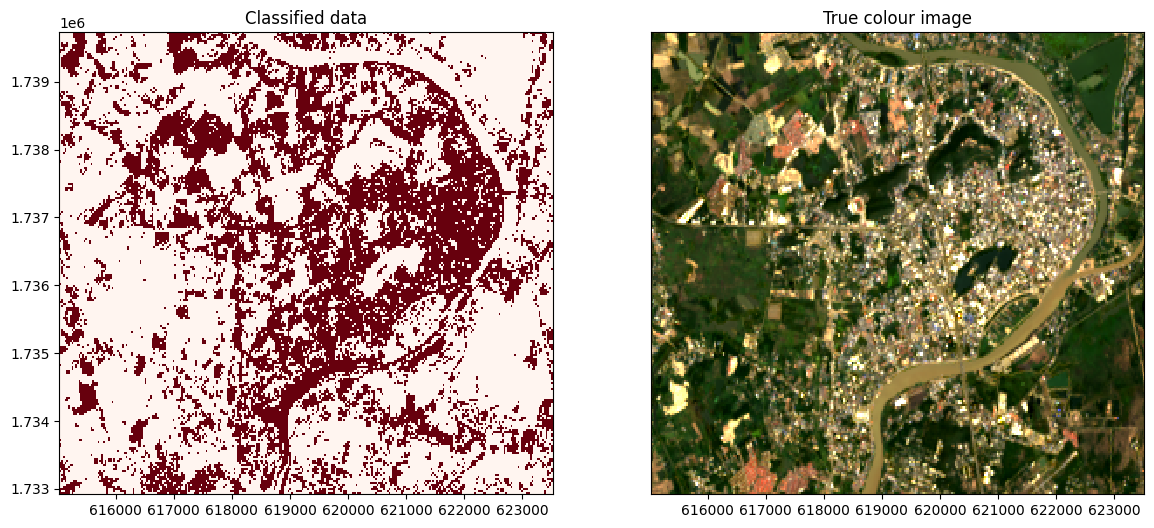

In [40]:
# Set up plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot classified image
predicted.Predictions.plot(ax=axes[0], 
               cmap='Reds', 
               add_labels=False, 
               add_colorbar=False)

# Plot true colour image
(input_data2[['red', 'green', 'blue']]
 .squeeze('time')
 .to_array()
 .plot.imshow(ax=axes[1], robust=True, add_labels=False))

# Remove axis on right plot
axes[1].get_yaxis().set_visible(False)

# Add plot titles
axes[0].set_title('Classified data')
axes[1].set_title('True colour image');

#### - Export in Geotiff

In [ ]:
# Write the predicted data out to a GeoTIFF
write_cog(predicted.Predictions,
         'Urban_predicted.tif',
          overwrite=True)